<a href="https://colab.research.google.com/github/Pratichhya/Pratichhya.github.io/blob/master/docs/documents/hurricane_dsc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Assignment for the completion of Data Science and Machine Learning Course

### Course No. 20W856113

### Students -  Pratichhya Sharma(12031082)  and Tanya Singh(12031084)


## Objective 
1. Perform Basic Statistical Analysis 
2. Comparitive Analysis of Random Forest and Decision Tree Algorithm for classifying Status of Hurricane
3. Predicting Maximum Wind and Minimum Pressure for hurricane OPHELIA in next 24 hours using RNN
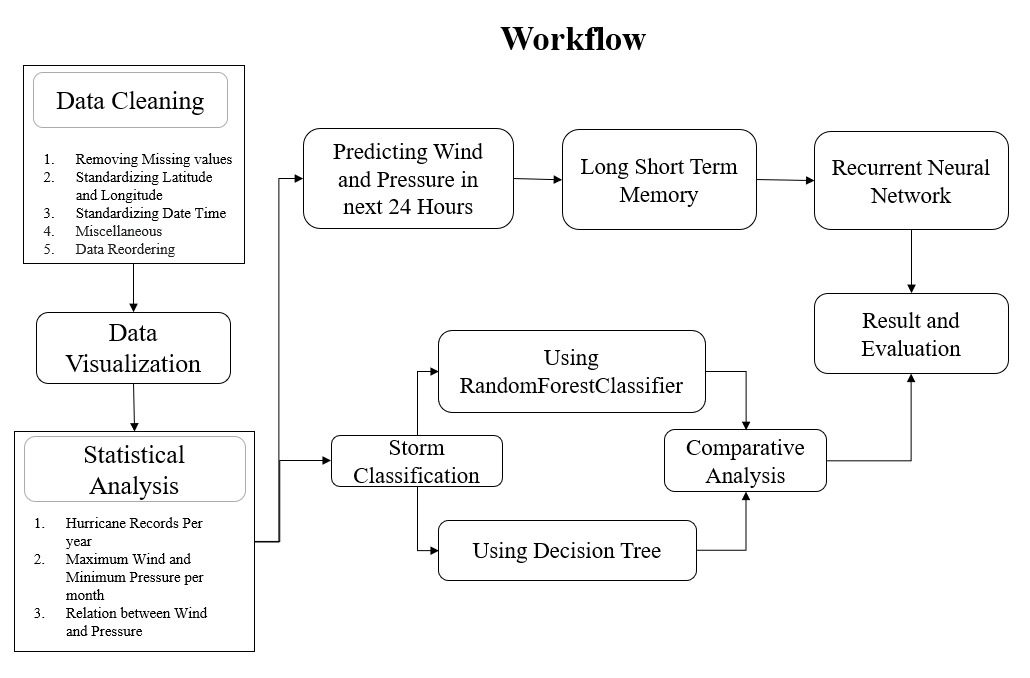

###  1. Importing Packages and Dataset

This data utilized in the study was provided as a part of course work of University of Salzburg. The data source is the revised Atlantic hurricane database (HURDAT2) - Chris Landsea, James Franklin, and Jack Beven – May 2015 - [data description](https://pratichhya.github.io/documents/dataset_des.pdf)

The task was completed in several sections that ranges from data cleaning, visualization, analysis, prediction and evaluation. For implementing Machine learning in this dataset, several python packages have been imported as per requirement


In [1]:
pip install cartopy

In [2]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sb
from matplotlib.animation import ArtistAnimation as aa
from IPython.display import HTML
import datetime

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, SimpleRNN

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/atlantic.csv")
data.head(10) #displaying initial 10 rows

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
5,AL011851,UNNAMED,18510626,0,,HU,28.2N,97.0W,70,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
6,AL011851,UNNAMED,18510626,600,,TS,28.3N,97.6W,60,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
7,AL011851,UNNAMED,18510626,1200,,TS,28.4N,98.3W,60,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
8,AL011851,UNNAMED,18510626,1800,,TS,28.6N,98.9W,50,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
9,AL011851,UNNAMED,18510627,0,,TS,29.0N,99.4W,50,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [4]:
print("The number of rows and columns for the initial data are :", data.shape)
print(" ")
print(data.describe())

The number of rows and columns for the initial data are : (49105, 22)
 
               Date          Time  ...  High Wind SW  High Wind NW
count  4.910500e+04  49105.000000  ...  49105.000000  49105.000000
mean   1.949802e+07    910.125975  ...   -877.923552   -877.786295
std    4.461850e+05    671.043363  ...    327.021430    327.408253
min    1.851062e+07      0.000000  ...   -999.000000   -999.000000
25%    1.911110e+07    600.000000  ...   -999.000000   -999.000000
50%    1.956093e+07   1200.000000  ...   -999.000000   -999.000000
75%    1.989081e+07   1800.000000  ...   -999.000000   -999.000000
max    2.015111e+07   2330.000000  ...    150.000000    180.000000

[8 rows x 16 columns]


From the initial observation of the data we can make out there are many missing values saved as -999 and -99, and the format of date and time also needs to be changed. These and many data cleaning methods will be performed in the following sections

### 2. Data Cleaning



### 2.1 Identifying and removing missing values

In [5]:
#converting all columns to string
dataList = list(data)
data[dataList] = data[dataList].astype(str)

# converting -999 and -99 as NaN
data = data.replace("-999" , np.NaN)
data = data.replace ("-99" , np.NaN)

#droping rows where atleast one element is missing
data = data.dropna()

#checking if any missing value is left
check = data.isnull()

### 2.2 Standardising Latitude and Longitude
The N/S/E/W tags needs to be removed for the Latitude and Longitude, and the datatype should be changed to numeric so as to fascilitate their usage in further analyses. Moreover, a minus sign needs to be added to the longitude values as they represent the western hemisphere. This was followed by the process of checking for outliers in the values of these attributes.

In [6]:
#removing N, S, E, W hemisphere tags from coordinates
data["Longitude"] = data["Longitude"].map(lambda x: x.rstrip("W"))
data["Latitude"] = data["Latitude"].map(lambda x: x.rstrip("N"))
data["Latitude"] = data["Latitude"].map(lambda x: x.rstrip("S"))
data["Longitude"] = data["Longitude"].map(lambda x: x.rstrip("E"))

In [7]:
#converting datatype of lat long from string to float
data["Latitude"]= pd.to_numeric(data["Latitude"], downcast = "float")
data["Longitude"]= pd.to_numeric(data["Longitude"], downcast = "float")

#adding "-" to longitude
data["Longitude"] = (data["Longitude"] * -1)

Latitude max value:  69.0
Latitude min value:  8.300000190734863


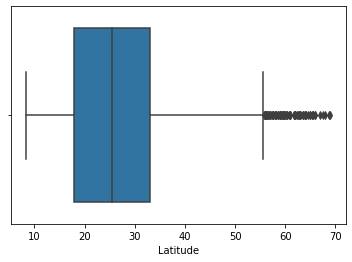

In [8]:
# checking for outliers in latitude
lat = data["Latitude"]
sb.boxplot(x=lat)
print("Latitude max value: ", lat.max())
print("Latitude min value: ", lat.min())

From the box-plot results we can infer that there are no anomalous outliers

Longitude max value:  -0.0
Longitude min value:  -106.69999694824219


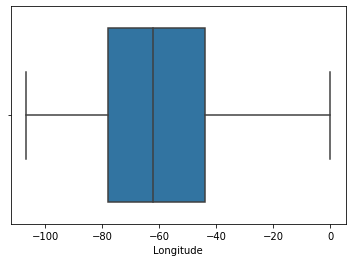

In [9]:
# checking outliers in longitude
long = data["Longitude"]
sb.boxplot(x= long)
print("Longitude max value: ", long.max())
print("Longitude min value: ", long.min())

### 2.3 Standardising Date and Time
The Time and Date column needs to concatenated according to the the ISO-8601 standard (Year-month-date-hour-minutes-second). To achieve this the time column was standardized to four figure unit by adding 0s infront of the data values. Furthurmore, we updated the format of Date, and made seperate Year and Month columns, which will be used in other sections.  

In [10]:
# Adding Time stamp to the DataFrame

#lambda function for adding zeros to Time
new_time = data["Time"].apply(lambda x: "{0:0>4}".format(x))
data["Time_Stamp"] = new_time


# Concatenating time and date 
timestamp = data["Date"]+ data["Time_Stamp"].astype(str)
timestamp_column = []

#updating timestamp according to ISO-8601
for x in timestamp:
    x_datetime = datetime.datetime.strptime(x, "%Y%m%d%H%M%S")
    timestamp_column.append(x_datetime)
    
#The new timestamp column
data["Timestamp"] = timestamp_column

#changing format of date
data["Date"] = pd.to_datetime(data["Date"], format = "%Y %m %d")

# adding year and month column for specific task
data["Year"] = data["Date"].map(lambda x : x.year)
data["Month"] = data["Date"].map(lambda x : x.month)

#removing the original time columns
data.drop("Time", axis ="columns", inplace = True)
data.drop("Time_Stamp", axis ="columns", inplace = True)

### 2.4 Miscellaneous
This section consists of additional data cleaning tasks such as removing unnecessary spaces in the event column and removing duplicate values in the DataFrame.

In [11]:
# Checking status column
old=pd.unique(data["Event"])
print(old)
# removing space before characters in column event
data["Event"] = data["Event"].replace([" L", " I", " S", " G", " W", " T", " P"], ["L", "I", "S", "G", "W", "T", "P"])
new= pd.unique(data["Event"])
print(new)

['  ' ' L' ' I' ' S' ' G' ' W' ' T' ' P']
['  ' 'L' 'I' 'S' 'G' 'W' 'T' 'P']


In [12]:
#checking for duplicate values
duplicate = data.duplicated(subset=None, keep ="first")
duplicateList = duplicate.tolist()

n=0 # counter for duplicate values

for i in duplicateList:
    if i == "True":
        n=n+1 
        
print("Number of duplicate values: ", n)

Number of duplicate values:  0


### 2.5 Data Reordering

In [13]:
data = data[["ID", "Name", "Timestamp", "Latitude", "Longitude", "Status","Event","Maximum Wind", "Minimum Pressure","Low Wind NE", "Low Wind SE", "Low Wind SW", "Low Wind NW",
       "Moderate Wind NE","Moderate Wind SE", "Moderate Wind SW","Moderate Wind NW", "High Wind NE", "High Wind SE", "High Wind SW",
       "High Wind NW", "Date", "Year", "Month"]]
data

,ID,Name,Timestamp,Latitude,Longitude,Status,Event,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Date,Year,Month
43104,AL012004,ALEX,2004-07-31 18:00:00,30.299999,-78.300003,TD,,25,1010,0,0,0,0,0,0,0,0,0,0,0,0,2004-07-31,2004,7
43105,AL012004,ALEX,2004-08-01 00:00:00,31.000000,-78.800003,TD,,25,1009,0,0,0,0,0,0,0,0,0,0,0,0,2004-08-01,2004,8
43106,AL012004,ALEX,2004-08-01 06:00:00,31.500000,-79.000000,TD,,25,1009,0,0,0,0,0,0,0,0,0,0,0,0,2004-08-01,2004,8
43107,AL012004,ALEX,2004-08-01 12:00:00,31.600000,-79.099998,TD,,30,1009,0,0,0,0,0,0,0,0,0,0,0,0,2004-08-01,2004,8
43108,AL012004,ALEX,2004-08-01 18:00:00,31.600000,-79.199997,TS,,35,1009,0,50,50,0,0,0,0,0,0,0,0,0,2004-08-01,2004,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,2015-11-12 12:00:00,41.299999,-50.400002,EX,,55,981,220,220,180,120,120,120,60,0,0,0,0,0,2015-11-12,2015,11
49101,AL122015,KATE,2015-11-12 18:00:00,41.900002,-49.900002,EX,,55,983,220,220,180,120,120,120,60,0,0,0,0,0,2015-11-12,2015,11
49102,AL122015,KATE,2015-11-13 00:00:00,41.500000,-49.200001,EX,,50,985,540,520,200,220,120,120,60,0,0,0,0,0,2015-11-13,2015,11
49103,AL122015,KATE,2015-11-13 06:00:00,40.799999,-47.500000,EX,,45,985,620,460,180,220,0,0,0,0,0,0,0,0,2015-11-13,2015,11


A qualitative dataset for analysis was assembled after removing the null values but the amount of dataset was reduced drastically when trying to meet the specific criteria.The initial dataset was reduced to 5921 rows (records) and 22 columns (attribute), with records available from 2004 to 2015.

### 3. Data Visualization 
Here, the movement of the hurricanes was vizualized using libraries from the cartopy package.  Additionally, a HTML representation of the hurricane movement was generated using 'Artistic Animation', through 2004 to 2015. Each hurricane was given a seperate color for a meaningful visualization.

In [ ]:
#to set single color for each hurricane based on name
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
model_colors ={}
for i, model in enumerate(data["Name"].unique()):
    model_colors[model] = colors[i%10]

#spatial projection
map_crs = ccrs.LambertConformal(central_latitude = 45, central_longitude = -80)

#coordinate reference system
data_crs = ccrs.PlateCarree() 

# plotting base map
fig = plt.figure(figsize = (17,12))
ax = plt.subplot(111,projection = map_crs)
ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth = 0.75) #to show the coastline

#ploting based on time stamp
artists = []
for d in data["Date"].unique():
    text = ax.text(0.5,1.02,f'Recorded {d}',ha ="center", transform = ax.transAxes, fontsize =24)
    timestep_artist = [text]
    time_df = data.loc[data["Date"] == d]
    
    #targeting one hurricane at a time
    for name in time_df["Name"].unique():
        name_path = time_df.loc[time_df["Name"]==name]
        s = ax.scatter(name_path["Longitude"], name_path["Latitude"], alpha = 0.5, transform = data_crs, color = model_colors[name])# scatter plot
        timestep_artist.append(s)
    artists.append(timestep_artist)
    #setting extent of plot
    ax.set_extent([-107, 1, 6, 70], crs = data_crs)

Geometry must be a Point or LineString


In [ ]:
#creating a animation video

plt.rcParams["animation.embed_limit"] = 2**128
anim = aa(fig,artists,interval = 100 )# time interval is 1 sec per frame
HTML(anim.to_jshtml())

### 4. Statistical Analysis

### 4.1 Hurricane record

Text(0, 0.5, 'Number')

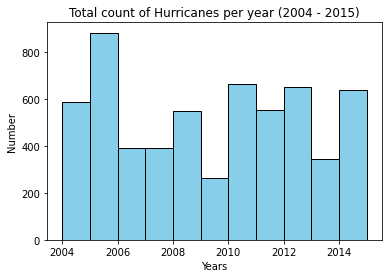

In [14]:
# Total hurricane record per year (2004 to 2015)

count = data["Year"].value_counts()
count_data = pd.DataFrame(count)
count_data = count_data.reset_index()
count_data = count_data.rename(columns={"index": "Year", "Year": "Total"})
count_data = count_data.sort_values(by = "Year", ascending = True)

#plot histogram
plt.hist(data["Year"], color = "skyblue", edgecolor = "black", bins = 11)
# Labels
plt.title("Total count of Hurricanes per year (2004 - 2015)")
plt.xlabel("Years")
plt.ylabel("Number")

The Histogram demonstrates a higher number of hurricanes recorded in the years 2004 to 2006, which gradually decreased until 2010 and eventually became more even in the later years. 

### 4.2  Analysing Maximum Wind and Minimum Pressure

* Affect of Pressure on Wind speed

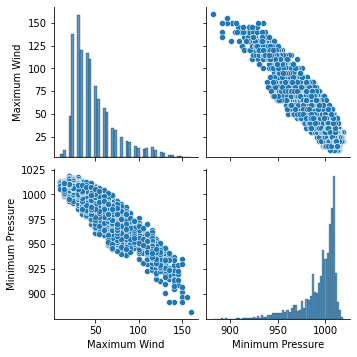

In [15]:
# Relation between Wind and Pressure

data["Maximum Wind"] = data["Maximum Wind"].astype(float)
data["Minimum Pressure"] = data["Minimum Pressure"].astype(float)

sb.pairplot(data,
    x_vars=["Maximum Wind", "Minimum Pressure"],
    y_vars=["Maximum Wind", "Minimum Pressure"],
)

We can infer here that wind speed and pressure are inversely related. This can be attributed to the simple physical law of movement of air from high pressure gradient to low pressure gradient.

* Identifying the month that is most susceptible to Hurricanes.

In [16]:
# Statistical analyses of maximum wind and minimum pressure in the hurricane center for each month

data["Month"] = data["Month"].astype(int)
group_month = data.groupby(["Month"])
describe_month = group_month.describe()
describe_month = pd.DataFrame(describe_month)
describe_month.drop("Longitude", axis = "columns", inplace = True)
describe_month.drop("Latitude", axis = "columns", inplace = True)
describe_month.drop("Year", axis = "columns", inplace = True)
describe_month

Maximum Wind                              ... Minimum Pressure                        
             count       mean        std   min  ...              25%     50%     75%     max
Month                                           ...                                         
1             28.0  41.964286  11.493902  25.0  ...           996.25  1000.0  1007.0  1016.0
5            131.0  35.419847  10.378198  25.0  ...          1001.00  1005.0  1007.0  1016.0
6            251.0  37.490040  12.715145  15.0  ...           994.00  1000.0  1005.0  1017.0
7            561.0  45.303030  24.533086  10.0  ...           995.00  1004.0  1009.0  1016.0
8           1414.0  47.312588  24.431800  15.0  ...           990.00  1004.0  1008.0  1019.0
9           2170.0  52.087558  26.188603  15.0  ...           982.00   997.0  1005.0  1016.0
10           958.0  48.429019  25.294724  10.0  ...           987.00   999.5  1006.0  1016.0
11           305.0  45.901639  17.055159  20.0  ...           987.00   996.0  1005.0  1010.0
12           103.0  43.106796  14.985557  20.0  ...           992.00   999.0  1006.5  1014.0

[9 rows x 16 columns]

Text(0.5, 0, 'Months')

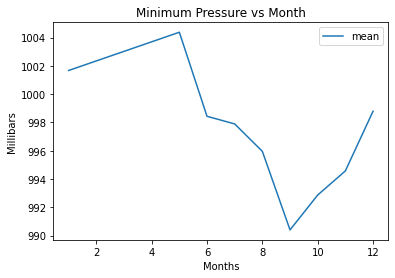

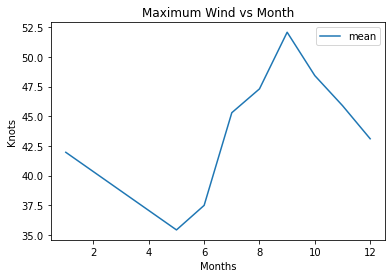

In [17]:
describe_month["Minimum Pressure"][["mean"]].plot()
plt.title("Minimum Pressure vs Month")
plt.ylabel("Millibars")
plt.xlabel("Months")

describe_month["Maximum Wind"][["mean"]].plot()
plt.title("Maximum Wind vs Month")
plt.ylabel("Knots")
plt.xlabel("Months")

 

The above two plots illustrate that the pressure started decreasing from May and becoming the least in September, also during the same period the wind speed started increasing, making Septemeber the most susceptible to hurricanes followed by October and August.

## 5. Storm Classification

    Status of storm can be of following types
    TD – Tropical cyclone of tropical depression intensity (< 34 knots)
    TS – Tropical cyclone of tropical storm intensity (34-63 knots)
    HU – Tropical cyclone of hurricane intensity (> 64 knots)
    EX – Extratropical cyclone (of any intensity)
    SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
    SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
    LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
    WV – Tropical Wave (of any intensity)
    DB – Disturbance (of any intensity)
    
    The value of status is assumed to be dependent Latitude, Longitude, Maximum Wind, Minimum Pressure, Low Wind NE, Low Wind SE, Low Wind SW, Low Wind NW, Moderate Wind NE, Moderate Wind SE, Moderate Wind SW, Moderate Wind NW, High Wind NE, High Wind SE, High Wind SW, High Wind NW 

### 5.1 Classification using Random Forest Classifier
The random forest classifier is a learning method especially used in classification process where random samples are selected from the dataset and a decision tree is constructed for each of the samples to predict the result for each of trees. The result with highest frequency is considered to be the predicted outcome.

In [18]:
# assigning training dataset
in_train = data[["Latitude","Longitude", "Maximum Wind", "Minimum Pressure","Low Wind NE", "Low Wind SE", "Low Wind SW", "Low Wind NW",
       "Moderate Wind NE","Moderate Wind SE", "Moderate Wind SW","Moderate Wind NW", "High Wind NE", "High Wind SE", "High Wind SW",
       "High Wind NW"]]
#classification outcome
out_train = data[["Status"]]

In [19]:
#forming the model
rf = RF(oob_score = True , n_estimators = 1000)

#fitting the model
rf.fit(in_train, out_train)

# identifying the weights of different features in the training set.
#The variables with maximum weight will be used for training
features = pd.Series(rf.feature_importances_ , index= in_train.columns).sort_values(ascending=False)
features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Maximum Wind        0.214924
Latitude            0.170166
Longitude           0.105209
Low Wind NE         0.096091
Minimum Pressure    0.079974
Low Wind SE         0.068052
High Wind NE        0.063279
High Wind SE        0.050018
Low Wind NW         0.039177
Low Wind SW         0.032476
High Wind NW        0.029027
High Wind SW        0.021068
Moderate Wind SW    0.009144
Moderate Wind SE    0.008628
Moderate Wind NE    0.006759
Moderate Wind NW    0.006008
dtype: float64

In [20]:
# taking the top 10 features
in_trainf = data[features.index[:11]]

# Here we will be using oob score as a measure of accuracy.

trees  = [100, 200 , 300, 500,900,1200,1500,2000]
maxn_ten = {}
maxn = {}
for i in trees:
    rf = RF(n_estimators=i , oob_score=True)
    rf.fit(in_trainf , out_train)
    print("Obb Score for {x} trees: and taking top ten features ".format(x = i) , rf.oob_score_)
    maxn_ten[i] = rf.oob_score_
    rf.fit(in_trainf , out_train)
    print("Obb Score for {x} trees: and taking all the features" .format(x = i) , rf.oob_score_)
    maxn[i] = rf.oob_score_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Obb Score for 100 trees: and taking top ten features  0.9121769971288634


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Obb Score for 100 trees: and taking all the features 0.915048133761189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Obb Score for 200 trees: and taking top ten features  0.9120081067387266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Obb Score for 200 trees: and taking all the features 0.9143725722006418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Obb Score for 300 trees: and taking top ten features  0.9157236953217361


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Obb Score for 300 trees: and taking all the features 0.9136970106400946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Obb Score for 500 trees: and taking top ten features  0.915048133761189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Obb Score for 500 trees: and taking all the features 0.916737037662557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Obb Score for 900 trees: and taking top ten features  0.9172437088329674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Obb Score for 900 trees: and taking all the features 0.9174125992231043


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Obb Score for 1200 trees: and taking top ten features  0.9172437088329674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Obb Score for 1200 trees: and taking all the features 0.9177503800033778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Obb Score for 1500 trees: and taking top ten features  0.915892585711873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Obb Score for 1500 trees: and taking all the features 0.9163992568822834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Obb Score for 2000 trees: and taking top ten features  0.9165681472724202


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Obb Score for 2000 trees: and taking all the features 0.916737037662557


In [21]:
# Split the data into training and testing.
in_trains , in_tests , out_trains, out_tests  = tts(in_trainf, out_train, test_size=0.33, random_state=42)

# Set n to the feature of maximum oob score.
n = 0
for i in maxn_ten:
    if max(maxn_ten.values()) == maxn_ten[i]:
        n= i
        
# Set n_estimators to n.
rf = RF(oob_score=True , n_estimators=n)
rf.fit(in_trains , out_trains)
out_pred_rf = rf.predict(in_tests[features.index[:11]])
print(out_pred_rf)
scores_rf = {'accuracy': accuracy_score(out_tests , out_pred_rf) ,"recall" : recall_score(out_tests , out_pred_rf , average="weighted") ,"precision" : precision_score(out_tests , out_pred_rf , average="weighted") }
print("For Random Forest classification with", n , " trees was used and the features considered were",  features.index[:11] , " to get following scores: ")
print("Accuracy: ", scores_rf["accuracy"])
print("Recall: " , scores_rf["recall"])
print("Precision: " , scores_rf["precision"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


[' TD' ' TD' ' TS' ... ' LO' ' LO' ' TS']
For Random Forest classification with 1200  trees was used and the features considered were Index(['Maximum Wind', 'Latitude', 'Longitude', 'Low Wind NE',
       'Minimum Pressure', 'Low Wind SE', 'High Wind NE', 'High Wind SE',
       'Low Wind NW', 'Low Wind SW', 'High Wind NW'],
      dtype='object')  to get following scores: 
Accuracy:  0.9037871033776868
Recall:  0.9037871033776868
Precision:  0.9039927301151947


### 5.2 Classification using Decision Tree
Classification with the decision tree classifier algorithm involves splitting of the data into several subsets which are trees with several nodes.  

In [22]:
model = DecisionTreeClassifier(min_samples_leaf =50, criterion = "entropy")

# assigning training dataset
in_train_dt = in_train
out_train_dt = out_train
features_dt = in_trainf

in_tra_dt, in_tes_dt, out_tra_dt, out_tes_dt = tts(features_dt, out_train_dt, test_size = 0.1)
model.fit(in_tra_dt, out_tra_dt)
predictions = model.predict(in_tes_dt)
print(predictions)

scores_dt = {'accuracy': accuracy_score(out_tes_dt ,predictions ) ,'recall' : recall_score(out_tes_dt , predictions , average='weighted') ,'precision' : precision_score(out_tes_dt , predictions , average='weighted') }
print('For Decision Tree classification 50 nodes were used and the features considered were',  features.index[:11] , ' to get the following scores: ')
print('Accuracy: ' , scores_dt['accuracy'])
print('Recall: ' , scores_dt['recall'])
print('Precision: ' , scores_dt['precision'])

[' HU' ' TS' ' HU' ' HU' ' HU' ' LO' ' HU' ' LO' ' TS' ' HU' ' TS' ' LO'
 ' EX' ' TS' ' HU' ' TS' ' EX' ' LO' ' HU' ' TD' ' HU' ' HU' ' TS' ' TS'
 ' TS' ' TS' ' TS' ' LO' ' TD' ' TS' ' TS' ' TD' ' LO' ' TS' ' TD' ' TD'
 ' TS' ' TS' ' EX' ' HU' ' HU' ' LO' ' HU' ' HU' ' TS' ' TS' ' HU' ' TS'
 ' TS' ' TD' ' TS' ' LO' ' LO' ' HU' ' LO' ' TD' ' TS' ' TS' ' TS' ' TS'
 ' TS' ' TD' ' LO' ' EX' ' TS' ' LO' ' TS' ' TS' ' HU' ' HU' ' TS' ' TS'
 ' LO' ' TS' ' LO' ' TD' ' LO' ' LO' ' TS' ' TS' ' LO' ' EX' ' EX' ' LO'
 ' LO' ' TD' ' TS' ' EX' ' TS' ' TS' ' TD' ' TS' ' LO' ' EX' ' TS' ' EX'
 ' HU' ' LO' ' TD' ' TS' ' LO' ' EX' ' EX' ' TS' ' HU' ' EX' ' EX' ' HU'
 ' TS' ' TS' ' HU' ' TS' ' LO' ' TS' ' HU' ' TD' ' TS' ' EX' ' TD' ' HU'
 ' TS' ' TS' ' LO' ' HU' ' HU' ' HU' ' TS' ' TD' ' EX' ' HU' ' EX' ' HU'
 ' TS' ' HU' ' TD' ' TS' ' EX' ' LO' ' TS' ' HU' ' HU' ' EX' ' TD' ' HU'
 ' TS' ' TS' ' TS' ' TD' ' TD' ' HU' ' TS' ' HU' ' LO' ' TS' ' HU' ' HU'
 ' HU' ' TS' ' LO' ' TS' ' HU' ' TS' ' TS' ' TS' ' 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.3 Comparitive Analyses of the two algorithms

In [23]:
compare = {'DecisionTree':scores_dt['accuracy'] , 'RandomForest': scores_rf['accuracy']}
max_value = max(compare.values())
max_index = ''
for i in compare:
    if compare[i] == max_value:
        max_index = i
print('The better algorithm is :' , max_index , 'with accuracy: ' , compare[max_index]) 

The better algorithm is : RandomForest with accuracy:  0.9037871033776868


## 6. Time-Series Prediction using RNN
We will be predicting the values of Maximum Wind and Minimum Pressure for the Hurricane Ophelia in the next 24 hour using the current and past values of the respective parameters. A Recurrent Neural Network (RNN) is well-suited to time series data as it is designed to exhibits temporal dynamic behaviour. The Long short term memory model of RNN is used for the prediction. 

###  6.1 Selecting the Hurricane 
The hurricane with maximum data quantity is selected, which turned out to be hurricane Ophelia. 

In [24]:
# Total count of hurricanes we have in our dataset 
hurricane_count = len(pd.unique(data['Name']))
print(hurricane_count)

# Since our keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(data['Name'])))

y = np.zeros((hurricane_count)) #numpy array to sort the hurricane data
for x in range(0,hurricane_count):
    y[x] = len(pd.DataFrame(data[data['Name'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    
# created the dataframe of y. 
hurricane_amount = pd.DataFrame(y)

# Print the hurricane key with the amount of data they contain
print ('Top 5 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(5, 0).index:
    top_hurricane = keys[x][1]
    print (top_hurricane, "-", hurricane_amount.loc[x][0])
    
    
# removing spaces before the name of the hurricane
data["Name"] = data["Name"].str.strip()

129
Top 5 Hurricanes (in terms of data quantity)
            OPHELIA - 128.0
             BERTHA - 121.0
             HELENE - 100.0
           DANIELLE - 97.0
             NADINE - 96.0


In [25]:
selected_hurricane = "OPHELIA"
selected_parameters = ["Maximum Wind" , "Minimum Pressure"]

# dataframe for OPHELIA
group_name = data.loc[data["Name"] == "OPHELIA"]
group_name = group_name.set_index("Timestamp")
group_name

,ID,Name,Latitude,Longitude,Status,Event,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Date,Year,Month
Timestamp,,,,,,,,,,,,,,,,,,,,,,,
2005-09-06 06:00:00,AL162005,OPHELIA,25.799999,-78.599998,TD,,25.0,1009.0,0,0,0,0,0,0,0,0,0,0,0,0,2005-09-06,2005,9
2005-09-06 12:00:00,AL162005,OPHELIA,26.299999,-78.300003,TD,,25.0,1010.0,0,0,0,0,0,0,0,0,0,0,0,0,2005-09-06,2005,9
2005-09-06 16:00:00,AL162005,OPHELIA,26.600000,-78.300003,TD,L,25.0,1010.0,0,0,0,0,0,0,0,0,0,0,0,0,2005-09-06,2005,9
2005-09-06 18:00:00,AL162005,OPHELIA,26.799999,-78.300003,TD,,25.0,1010.0,0,0,0,0,0,0,0,0,0,0,0,0,2005-09-06,2005,9
2005-09-07 00:00:00,AL162005,OPHELIA,27.400000,-78.500000,TD,,30.0,1006.0,0,0,0,0,0,0,0,0,0,0,0,0,2005-09-07,2005,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-10-03 12:00:00,AL162011,OPHELIA,47.400002,-54.000000,EX,,50.0,994.0,150,250,150,60,70,100,0,0,0,0,0,0,2011-10-03,2011,10
2011-10-03 18:00:00,AL162011,OPHELIA,48.900002,-49.200001,EX,,45.0,994.0,150,250,175,60,0,0,0,0,0,0,0,0,2011-10-03,2011,10
2011-10-04 00:00:00,AL162011,OPHELIA,49.900002,-43.599998,EX,,40.0,994.0,0,250,0,0,0,0,0,0,0,0,0,0,2011-10-04,2011,10


### 6.2 Training and Testing Dataset

The datasets for Ophelia are recorded from 2005-06-09 to 2011-10-03 and the prediction would be made for 2011-10-05. To shift to the next 24 hours we need to shift 5 steps as for a single day 5 sets of data are available (06:00, 12:00, 16:00, 18:00, 00:00). 
A new data frame with null values in the last 5 rows is created which stores the predicted values.

The graph here is a time-series example wherein the value of WP changes with time. x is the initial WP values for time t1 to tn and y is the 24 hr shifted WP values for t1+24 to tn+24.

y = f(x)

The value of wind and pressure are independant of other variables but dependant on their own values over time. 



In [28]:
shift_steps = 5  
df_targets = group_name[selected_parameters].shift(-shift_steps) #targeted data frame with null values in the last 5 rows for wind and pressure
# Assigning the input and output values based on y =f(x)
x_data = group_name[selected_parameters][0:-(shift_steps)].values
y_data = df_targets.values[:-shift_steps] 

The process is then followed by spliting the data into training and testing sets. 90% of the data is used for training and the remaining 10% for testing the model. It was computed that out of 123 Ophelia datasets, 110 random samples will be taken as training set and remaining 13 as testing set values.


In [29]:
# Division into training and testing
num_data=len(x_data)
train_split = 0.9
num_train = int(train_split * num_data)
print("Number of training set values ", num_train)
num_test = num_data - num_train
print("Number of testing set values ", num_test)

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print ("Total data ",len(y_train) + len(y_test))

Number of training set values  110
Number of testing set values  13
Total data  123


### 6.3 Scaling
The process of scaling is done to normalize the values between 0 to 1 to speed up the learning process. 

In [30]:
#Normalizing the data generally speeds up learning and leads to faster convergence.
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


### 6.4 Building the Model
For prediction, the sequential learner, LSTM model with kernel size of 5 and ReLU activation function is built.

In [31]:
# 2 input signals to get 2 output signals (wind and pressure)
num_x_signals=2 
num_y_signals=2

#Deletion of previous model is done to avoid complication when running the model multiple times
del model 
tf.keras.backend.clear_session() 

#The model
model = tf.keras.models.Sequential([
 tf.keras.layers.Conv1D(filters=60, kernel_size=5,
 strides=1, padding="causal",
 activation="relu",
 input_shape=[None, 2]),
 tf.keras.layers.LSTM(60, return_sequences=True),
 tf.keras.layers.LSTM(60, return_sequences=True),
 tf.keras.layers.Dense(30, activation="relu"),
 tf.keras.layers.Dense(10, activation="relu"),
 tf.keras.layers.Dense(2),
 tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          660       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 2)           22        
_________________________________________________________________
lambda (Lambda)              (None, None, 2)           0

Now, we will compute the mean squared error as the loss and use RMSprop optimiser to normalize the gradient of Loss. The optimizer monitors the loss values and update the biases and weights of all layers so that it gives the best output.

In [32]:
# checking error
opt=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
mse=tf.keras.losses.MeanSquaredError()
#LOSS, Optimizer, Accuracy ; 
model.compile(optimizer=opt,loss=mse,metrics=[tf.keras.metrics.MeanAbsoluteError()]) 

### 6.5 Training the Model
Now we can train the neural network and check its performance by plotting the training loss and training error

In [33]:
NUMBER_EPOCHS = 100
def train(model, xvalues, yvalues):
    hist = model.fit(x=xvalues,
                     y=yvalues,
                     epochs=NUMBER_EPOCHS,
                     batch_size=2
                     #sample_weight=sample_weight
                    )
    return hist
xtrain= np.expand_dims(x_train_scaled, axis=0)
ytrain=np.expand_dims(y_train_scaled, axis=0)
history = train(model, xtrain, ytrain)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 805.5473 - mean_absolute_error: 24.6670
Epoch 2/100
1/1 [==============================] - 0s 77ms/step - loss: 310.3916 - mean_absolute_error: 14.9580
Epoch 3/100
1/1 [==============================] - 0s 80ms/step - loss: 156.3626 - mean_absolute_error: 10.5100
Epoch 4/100
1/1 [==============================] - 0s 79ms/step - loss: 91.4744 - mean_absolute_error: 7.9864
Epoch 5/100
1/1 [==============================] - 0s 75ms/step - loss: 60.4625 - mean_absolute_error: 6.6193
Epoch 6/100
1/1 [==============================] - 0s 79ms/step - loss: 43.5485 - mean_absolute_error: 5.6962
Epoch 7/100
1/1 [==============================] - 0s 78ms/step - loss: 33.7543 - mean_absolute_error: 5.0393
Epoch 8/100
1/1 [==============================] - 0s 79ms/step - loss: 27.5486 - mean_absolute_error: 4.5287
Epoch 9/100
1/1 [==============================] - 0s 76ms/step - loss: 23.3328 - mean_absolute_error: 4.1230
Epoch 

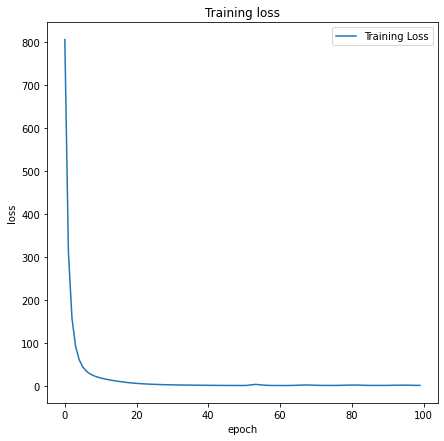

In [34]:
# plot learning curve
plt.figure(figsize=(7,7))
plt.plot(history.history["loss"],label='Training Loss')
plt.title("Training loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

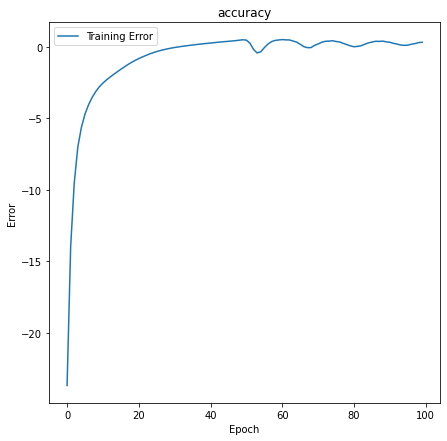

In [35]:
# plot learning curve
plt.figure(figsize=(7,7))
plt.plot(1-np.array(history.history["mean_absolute_error"]),label='Training Error')
plt.title("accuracy")
plt.ylabel("Error")
plt.xlabel("Epoch")
#plt.plot(1-np.array(history.history["val_acc"]),label='Validation Error')
plt.legend()
plt.show()

### 6.6 Testing the Model
Testing was done on the data that the model has not seen.

In [36]:
#test the model
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 1s 1s/step - loss: 16.5175 - mean_absolute_error: 3.1745


### 6.7 Prediction

In [37]:
eval_set=len(group_name)-shift_steps
x_eval= group_name[selected_parameters][eval_set:].values
y_eval=df_targets.values[:-(shift_steps*2)]# -shift_steps because you dont want the nan values in data and the last ones will be used for prediction.

In [38]:
x_pred=x_scaler.transform(x_eval)
x_pred = np.expand_dims(x_pred, axis=0)
#prediction
y_pred=model.predict(x_pred)

y_pred=y_pred.reshape((5,2))
#transformation of predicted values
y_pred_transformed=y_scaler.inverse_transform(y_pred)

In [39]:
#adding initially known time as index to the outcome
time_id=["06:00", "12:00", "16:00", "18:00", "00:00"]

#creating dataframe for predicted values
df_predicted = pd.DataFrame(y_pred_transformed, columns = ['Max wind','Min Pressure'])
print("The predicted Maximum wind (knots) and minimum pressure values (millibars) are : ")

df_predicted["time_id"] = time_id
df_predicted

The predicted Maximum wind (knots) and minimum pressure values (millibars) are : 


,Max wind,Min Pressure,time_id
0,70.566414,958.507080,06:00
1,114.825737,992.510681,12:00
2,106.825340,996.595825,16:00
3,81.840508,978.856934,18:00
4,71.582176,975.618835,00:00


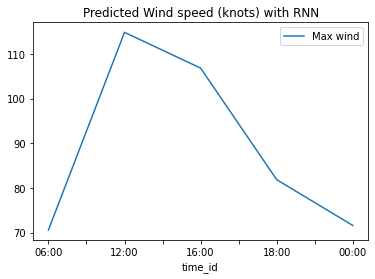

In [40]:
df_predicted.plot(x="time_id", y ="Max wind", title ="Predicted Wind speed (knots) with RNN")

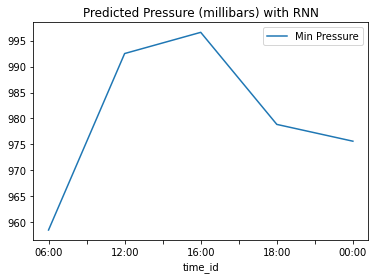

In [41]:
df_predicted.plot(x="time_id", y ="Min Pressure", title ="Predicted Pressure (millibars) with RNN")

## 7. Conclusion

Thus, the assignment successfully explains the correlation between hurricane wind speed and pressure. The comparitive analysis of the two commonly used machine learning algorithms, Random forest and Decision tree shows that for classification, the former gives better accuracy than the latter.

The basic difference between the two is that unlike decision tree, random forest does not rely on a singular decision. It assembles randomized decisions based on several decisions and makes the final decision based on the majority. It does not search for the best prediction. Instead, it makes multiple random predictions. Thus, more diversity is attached, and prediction becomes much smoother.We can infer Random forest to be a collection of multiple decision trees!

For time series prediction of the maximum wind speed and minimum pressure although the model worked reasonably well on the testing dataset showing low mean absolute error and good accuracy yet the predictions are not satisfactory.

Maybe, the results can be improved by using another variable like temperature, so that a dependancy is created between the the input and output data. 

